In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

NAME: Sarvesh Nirmalkar

ROLL NO:38

SRN : 02FE22BCS112

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [27]:
train_dataset_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
validation_dataset_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

In [28]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [29]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


In [30]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


In [31]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


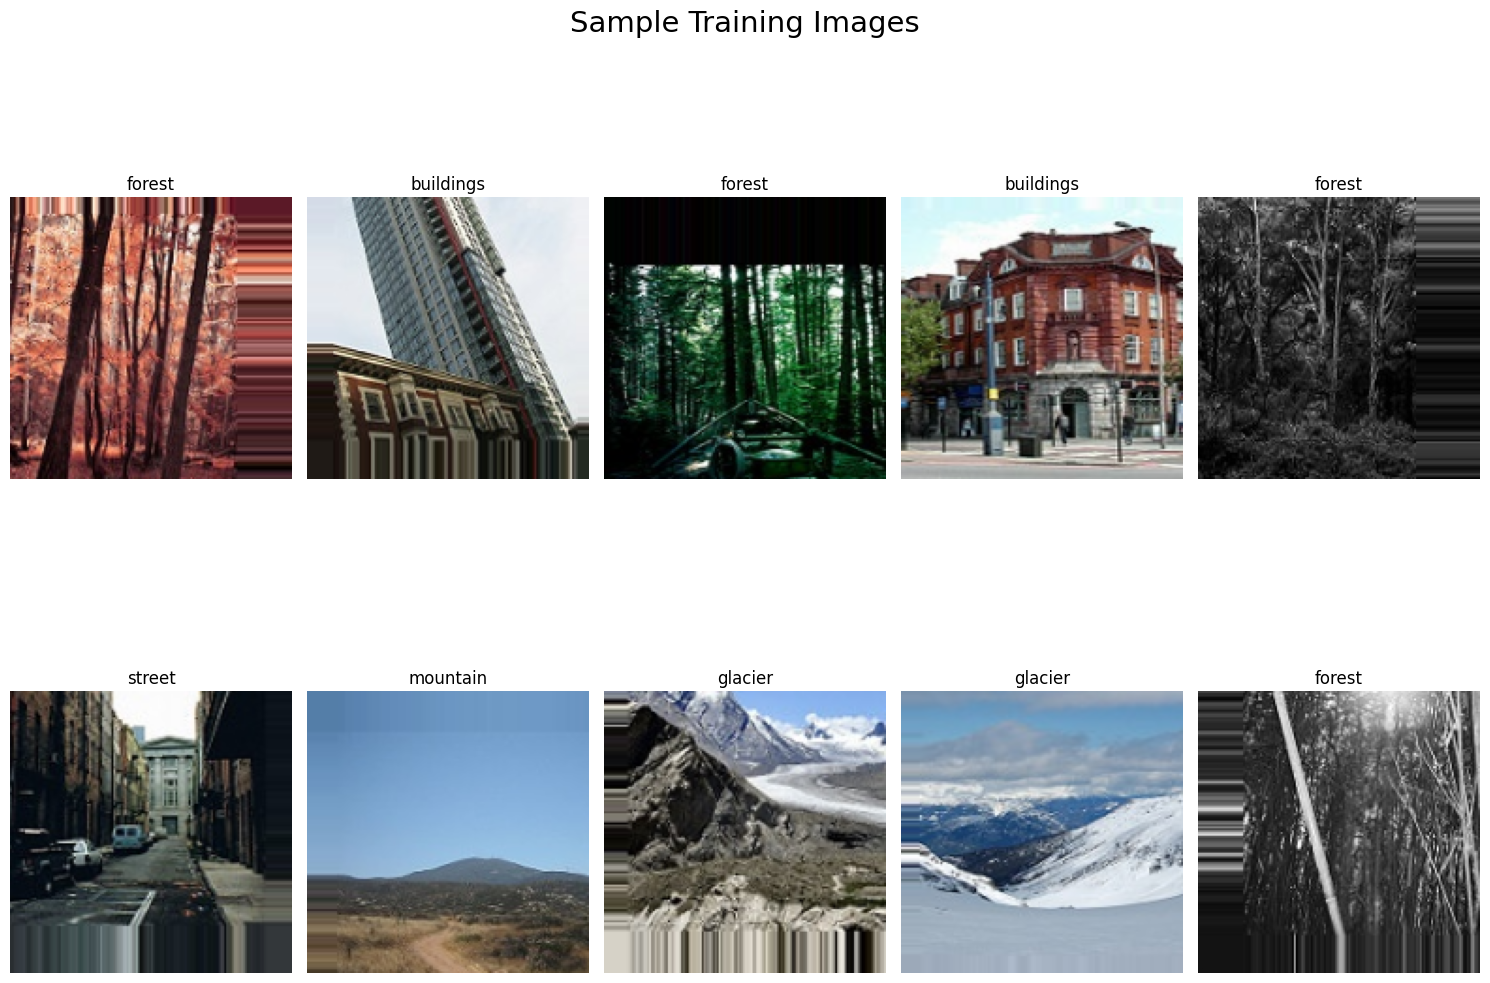

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [33]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

In [34]:
cnn_model = create_model()

In [36]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)

In [37]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [38]:
history = cnn_model.fit(train_generator, epochs=5, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/5
439/439 - 94s - 213ms/step - accuracy: 0.4976 - loss: 2.0008 - val_accuracy: 0.4880 - val_loss: 1.6904 - learning_rate: 0.0010
Epoch 2/5
439/439 - 82s - 186ms/step - accuracy: 0.6010 - loss: 1.0913 - val_accuracy: 0.5073 - val_loss: 1.2467 - learning_rate: 0.0010
Epoch 3/5
439/439 - 81s - 185ms/step - accuracy: 0.6667 - loss: 0.9197 - val_accuracy: 0.4067 - val_loss: 2.7606 - learning_rate: 0.0010
Epoch 4/5
439/439 - 82s - 186ms/step - accuracy: 0.6926 - loss: 0.8411 - val_accuracy: 0.5893 - val_loss: 1.3758 - learning_rate: 0.0010
Epoch 5/5
439/439 - 82s - 186ms/step - accuracy: 0.7104 - loss: 0.8000 - val_accuracy: 0.5980 - val_loss: 1.1157 - learning_rate: 0.0010


In [42]:


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

import tensorflow.keras.backend as K


learning_rate = K.get_value(cnn_model.optimizer.learning_rate)



Final learning rate: 0.0010000000474974513


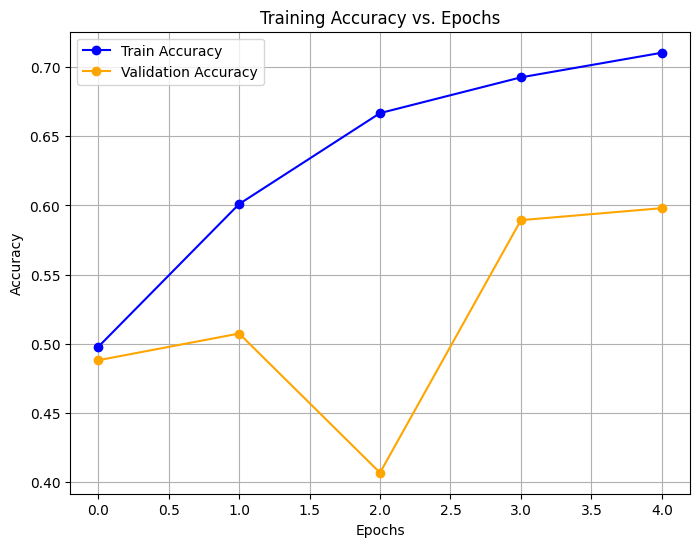

In [44]:
# Training and Validation Accuracy Plot
plt.figure(figsize=(8, 6))
plt.title('Training Accuracy vs. Epochs')
plt.plot(train_accuracy, 'o-', label='Train Accuracy', color='blue')
plt.plot(val_accuracy, 'o-', label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

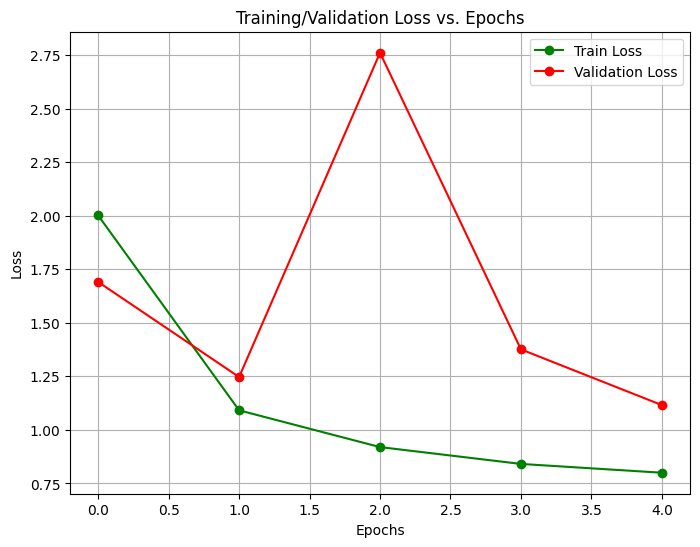

In [45]:
plt.figure(figsize=(8, 6))
plt.title('Training/Validation Loss vs. Epochs')
plt.plot(train_loss, 'o-', label='Train Loss', color='green')
plt.plot(val_loss, 'o-', label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [46]:
test_dataset = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

In [47]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [48]:
predictions = cnn_model.predict(test_generator)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


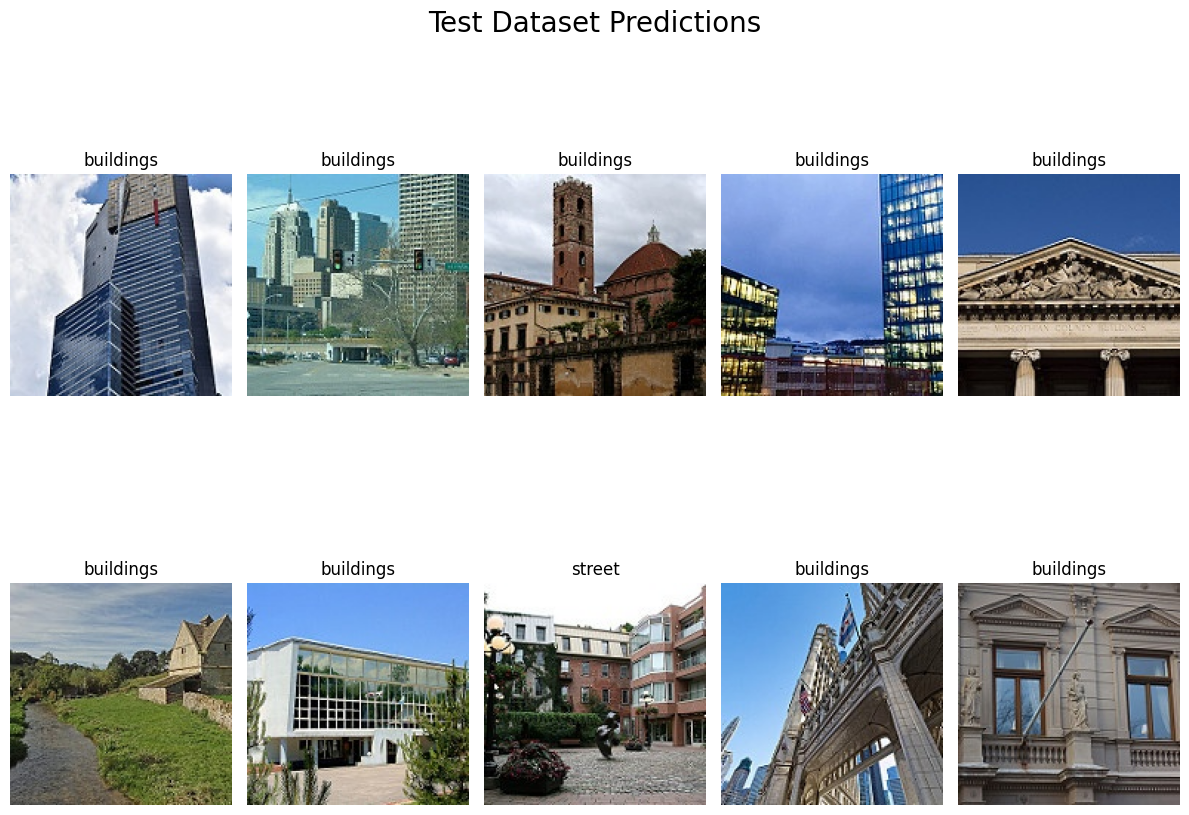

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [54]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy*100}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6601 - loss: 0.9737
Test Loss:     1.115739107131958
Test Accuracy: 59.79999899864197


In [55]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

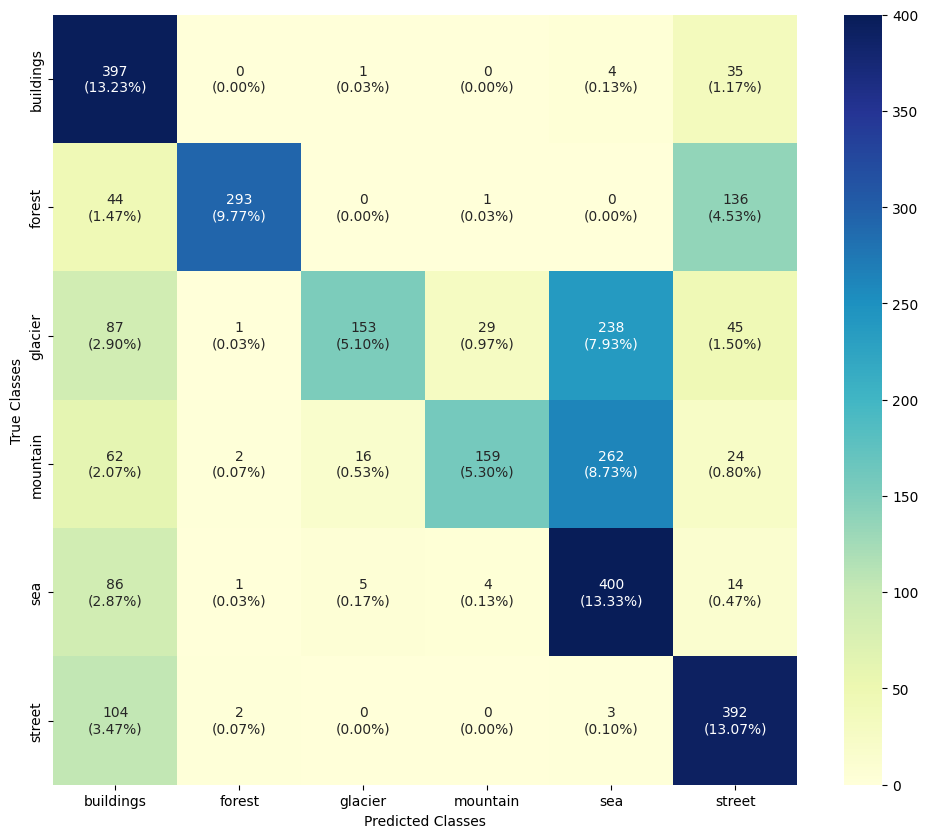

In [56]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [57]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.51      0.91      0.65       437
      forest       0.98      0.62      0.76       474
     glacier       0.87      0.28      0.42       553
    mountain       0.82      0.30      0.44       525
         sea       0.44      0.78      0.56       510
      street       0.61      0.78      0.68       501

    accuracy                           0.60      3000
   macro avg       0.71      0.61      0.59      3000
weighted avg       0.71      0.60      0.58      3000

